In [80]:
from cfg import *
import rpy2
import PrimaryLibrary as PL
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RandomizedLasso
stability_selection = RandomizedLasso(normalize = False, alpha = 0.01)

imp.reload(PL)

GeneExp        = h5py.File('G_Exp.hdf5', 'r')['dataset1']
ConDict        = pk.load(open('CreLineDict.pkl','rb'))
MesoPred = PL.MesoconnectomePredictor()
a,b,c,d  = MesoPred.PreProcessing(GeneExp[MesoPred.params['leaf_keys'],:], 
                                  MesoPred.params,
                                  ConDict['wild_type']['ConMat'][MesoPred.params['leaf_keys'],:])
         
GeneMeta       = pk.load(open('GeneMeta.pkl','r'))
clear_output()

In [2]:
ClfResults_ridge = {}; ridge_pred = {}
MesoPred.params           = pk.load(open('updated_params.pkl','rb'))
for key in ConDict.keys():
    if os.path.isfile('saves/' + key + '_all_results' + '_ridge.pkl') == True:
        infile = 'saves/' + key + '_all_results' + '_ridge.pkl'
        tmp = pk.load(open(infile,'r'))
        ClfResults_ridge[key] = {key:val for key,val in tmp.items()}
gene_scores = np.asarray([tracer[0] for key in ClfResults_ridge.keys() for tracer in ClfResults_ridge[key]['r2']])
clear_output()

In [3]:
def Predictive_Shortcut(ClfResults_ridge, Code, key = 'all', exp_id = None):
    ridge_params = {'alpha': [1,10,100,250,500,1000],
                    'fit_intercept' : [True], 'normalize' : [False]}
                                       
    ridge_pred = {}
    if key == 'all':
        key_list = ClfResults_ridge.keys()
    else:
        key_list = [key]
        
    for key in key_list:
        ridge_pred[key] = {'r2': [],'coef': []}
        
        if exp_id == None:
            y_pred = np.zeros(np.shape(ClfResults_ridge[key]['y_actual']))
        else:
            y_pred = np.zeros((len(ClfResults_ridge[key]['y_actual']),1))
            
        Code_scale = StandardScaler().fit_transform(Code) 
        if exp_id == None:
            projection_scaler = StandardScaler().fit(ClfResults_ridge[key]['y_actual'])
            y_meas_scale = projection_scaler.transform(ClfResults_ridge[key]['y_actual'])
        else:
            projection_scaler = StandardScaler().fit(np.reshape(ClfResults_ridge[key]['y_actual'][:,exp_id],(-1,1)))
            y_meas_scale = projection_scaler.transform(np.reshape(ClfResults_ridge[key]['y_actual'][:,exp_id],(-1,1)))
        for train, test in MesoPred.params['validation'].split(Code,ClfResults_ridge[key]['y_actual']):
            ridge_mdl = GridSearchCV(Ridge(random_state = 10), param_grid = ridge_params, 
                                     scoring = 'neg_mean_squared_error', 
                                     cv = 3, n_jobs = -1)
            if exp_id == None:
                ridge_mdl.fit(Code_scale[train], y_meas_scale[train])
                y_pred[test] = ridge_mdl.predict(Code_scale[test]) 
            else:
                ridge_mdl.fit(Code_scale[train], y_meas_scale[train,0])
                y_pred[test,0] = ridge_mdl.predict(Code_scale[test]) 
        
        if exp_id == None:
            ridge_mdl.fit(Code_scale, y_meas_scale)    
            ridge_pred[key]['coef'] = Ridge(**ridge_mdl.best_params_).fit(Code_scale, y_meas_scale).coef_
            ridge_pred[key]['r2'] = metrics.r2_score(y_meas_scale, y_pred, multioutput = 'raw_values')
        else:
            ridge_mdl.fit(Code_scale, y_meas_scale[:,0])    
            ridge_pred[key]['coef'] = Ridge(**ridge_mdl.best_params_).fit(Code_scale, y_meas_scale[:,0]).coef_
            ridge_pred[key]['r2'] = metrics.r2_score(y_meas_scale[:,0], y_pred[:,0])
    
        if exp_id == None:    
            ridge_pred[key]['y_pred'] = projection_scaler.inverse_transform(y_pred)
        else: 
            ridge_pred[key]['y_pred'] = projection_scaler.inverse_transform(y_pred[:,0])
    
    if exp_id == None:      
        all_scores = np.asarray([tracer for key in ridge_pred.keys() for tracer in ridge_pred[key]['r2']])  
    else: 
        all_scores = []
        
    #clear_output()
    
    return ridge_pred, all_scores 

In [120]:
print 'Sparsity: {}'.format(np.median([len(Code[:,idx][Code[:,idx] > 0])/(1.0*len(Code)) for idx in range(len(Code[0]))]))
print 'Participation: {}'.format(np.median([len(Atoms[idx,:][Atoms[idx,:] > 0])/(1.0*len(Atoms[0])) for idx in range(len(Code[0]))]))

Sparsity: 0.885514018692
Participation: 0.106690777577


In [ ]:
Temp_dict = {}
iqr_dict = {}
for components in [10,25,50,100,150,200,300,500]:
    print 'no of components: {}'.format(components)
    Code, Atoms, dlsc_mdl = MesoPred.DictionaryDecomposition(np.transpose(ClfResults_ridge['wild_type']['Gene Expression']),
                                                  n_comp = components, alpha = 0.1,
                                                  transform_alpha = None, state = 0)                                                      
    Atoms = np.transpose(Atoms); Code = np.transpose(Code)
    module_based_pred, all_scores = Predictive_Shortcut(ClfResults_ridge, Code)   
    Temp_dict[components] = np.median(all_scores)
    iqr_dict[components] = sci.stats.iqr(all_scores)

pk.dump(Temp_dict, open('paper1_figures/for_paul_20_6_19/Temp_dict.pkl','wb'))    
pk.dump(iqr_dict, open('paper1_figures/for_paul_20_6_19/iqr_dict.pkl','wb'))  

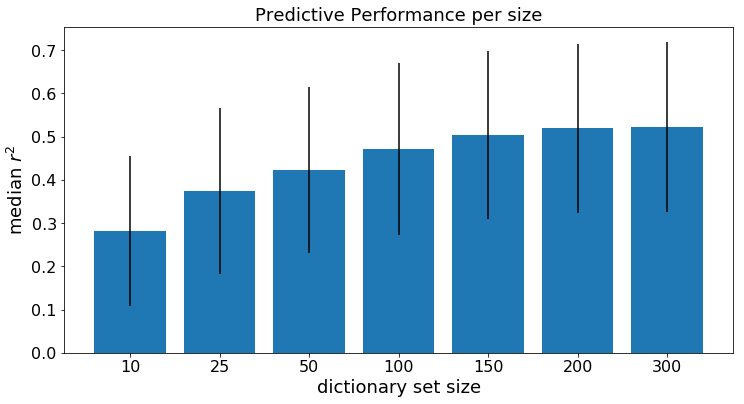

In [192]:
order = np.argsort(Temp_dict.keys())
values = list(Temp_dict.values()); iqr_vals = list(iqr_dict.values())
new_val = [values[idx] for idx in order]
iqr_val = [iqr_vals[idx] for idx in order]
 
order = np.argsort(Temp_dict.keys())
values = list(Temp_dict.values()) 
new_val = [values[idx] for idx in order]
new_key = [str(Temp_dict.keys()[idx]) for idx in order]
plt.figure(figsize = (12,6))
plt.bar(new_key, new_val, yerr = iqr_val)
ax = plt.gca(); ax.xaxis.set_tick_params(labelsize = 16); ax.yaxis.set_tick_params(labelsize = 16)
plt.ylabel(r'median $r^2$', fontsize = 18)
plt.xlabel('dictionary set size', fontsize = 18)   
plt.title('Predictive Performance per size', fontsize = 18)
plt.savefig('paper1_figures/for_paul_20_6_19/dictionary_to_performance2.jpg')

In [81]:
#Code, Atoms, dlsc_mdl = MesoPred.DictionaryDecomposition(np.transpose(ClfResults_ridge['wild_type']['Gene Expression']),
#                                              n_comp = 200, alpha = 0.1,
#                                              transform_alpha = None, state = 0)                                                      
#Atoms = np.transpose(Atoms); Code = np.transpose(Code)
#module_based_pred, all_scores = Predictive_Shortcut(ClfResults_ridge, Code)   
 
#Atoms, Code, dlsc_mdl = MesoPred.DictionaryDecomposition(ClfResults_ridge['wild_type']['Gene Expression'],
#     n_comp = 200)            
#pk.dump(Atoms, open('paper1_figures/for_paul_20_6_19/Atoms.pkl', 'wb'))
#pk.dump(Code, open('paper1_figures/for_paul_20_6_19/Code.pkl', 'wb'))
#pk.dump(dlsc_mdl, open('paper1_figures/for_paul_20_6_19/dlsc_mdl.pkl', 'wb'))  
Atoms = pk.load(open('paper1_figures/for_paul_20_6_19/Atoms.pkl', 'rb'))
Code = pk.load(open('paper1_figures/for_paul_20_6_19/Code.pkl', 'rb'))
dlsc_mdl = pk.load(open('paper1_figures/for_paul_20_6_19/dlsc_mdl.pkl', 'rb'))  

### Codify_Modules takes a set of modules and a set of projection patterns and codifies their correlations into a new spatial pattern

In [7]:
def Codify_Modules(Code, Proj_pat, code_set):
    new_code = np.zeros((len(Code),1))
    for area in range(len(Code)):
        mod_sub = [Code[area,subset] for subset in code_set]
        nonzero_mods = np.nonzero(mod_sub)[0]
        if Proj_pat[area] > 0 and len(nonzero_mods) > 0:
            if len(nonzero_mods) == 1:
                new_code[area] = 0.6    
            elif len(nonzero_mods) == 2:
                new_code[area] = 0.8
            elif len(nonzero_mods) == 3:
                new_code[area] = 1.0    
        elif Proj_pat[area] > 0 and len(nonzero_mods) == 0:
            new_code[area] = 0.4
        elif Proj_pat[area] == 0 and len(nonzero_mods) > 0:
            new_code[area] = 0.2
        else:
            new_code[area] = 0
            
    return new_code            


### Another Part: predict Axonal projections from spatial modules

In [113]:
print exp_to_mod_cor['Cux2-IRES-Cre']['top_mods'][57]
print exp_to_mod_cor['Cux2-IRES-Cre']['local correlations'][57]
print exp_to_mod_cor['Cux2-IRES-Cre']['global correlations'][57]
print exp_to_mod_cor['Cux2-IRES-Cre']['top_three_r2'][57]
print np.median(all_mod_to_proj_cor)

[70  9 88]
[ 0.52361567  0.51731701  0.45031375]
0.622469576202
0.386173239142
0.544009093966


In [116]:
print np.median(all_scores), sci.stats.iqr(all_scores), np.max(all_scores)

0.51624586425 0.195674564337 0.791152983732


In [13]:
exp_to_mod_cor = {}
# Rinse and repeat for all tracing experiments
for key in ClfResults_ridge.keys():
    exp_to_mod_cor[key] = {'local correlations' : [], 'global correlations' : [], 
                           'top_mods' : [],'pval' : [], 'y_pred': [], 'top_three_r2' : []}
    for inj in range(len(ClfResults_ridge[key]['y_actual'][0])):
        temp = [abs(sci.stats.pearsonr(ClfResults_ridge[key]['y_actual'][:,inj], Code[:,idx])[0]) for idx in range(len(Code[0]))]
        top_mods = np.argsort(temp)[::-1][0:3]
        module_based_pred, all_scores = Predictive_Shortcut(ClfResults_ridge, Code[:,top_mods], 
                                                            key = key, exp_id = inj) 
        corr = sci.stats.pearsonr(ClfResults_ridge[key]['y_actual'][:,inj], module_based_pred[key]['y_pred'])
        exp_to_mod_cor[key]['local correlations'].append(np.sort(temp)[::-1][0:3])
        exp_to_mod_cor[key]['global correlations'].append(corr[0])
        exp_to_mod_cor[key]['pval'].append(corr[1])
        exp_to_mod_cor[key]['top_mods'].append(top_mods)
        exp_to_mod_cor[key]['y_pred'].append(module_based_pred[key]['y_pred'])
        exp_to_mod_cor[key]['top_three_r2'].append(module_based_pred[key]['r2'])


/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/skl

In [45]:
#module_based_pred, all_scores = Predictive_Shortcut(ClfResults_ridge, Code)
#pk.dump(module_based_pred, open('paper1_figures/for_paul_20_6_19/module_based_pred.pkl', 'wb'))
#pk.dump(all_scores, open('paper1_figures/for_paul_20_6_19/all_scores.pkl', 'wb'))
#pk.dump(exp_to_mod_cor, open('paper1_figures/for_paul_20_6_19/exp_to_mod_cor.pkl', 'wb'))
module_based_pred = pk.load(open('paper1_figures/for_paul_20_6_19/module_based_pred.pkl', 'rb'))
all_scores = pk.load(open('paper1_figures/for_paul_20_6_19/all_scores.pkl', 'rb'))
top_perf_per_cre = [(key, np.argmax(module_based_pred[key]['r2']),np.max(module_based_pred[key]['r2'])) for key in module_based_pred.keys()]
clear_output()
print top_perf_per_cre
print exp_to_mod_cor['Cux2-IRES-Cre']['top_mods'][57]
#print metrics.r2_score(ClfResults_ridge['wild_type']['y_actual'][:,39], exp_to_mod_cor['wild_type']['y_pred'][39])
#print sci.stats.pearsonr(ClfResults_ridge['wild_type']['y_actual'][:,39], exp_to_mod_cor['wild_type']['y_pred'][39])
#print exp_to_mod_cor['wild_type']['global correlations'][PAA_pos[0]], exp_to_mod_cor['wild_type']['global correlations'][39]
#print exp_to_mod_cor['wild_type']['top_mods'][PAA_pos[0]], exp_to_mod_cor['wild_type']['top_mods'][39]

[('Nr5a1-Cre', 10, 0.69478256416405104), ('Scnn1a-Tg3-Cre', 12, 0.70844038429600742), ('Ntsr1-Cre_GN220', 3, 0.65547676414476697), ('Emx1-IRES-Cre', 57, 0.73134836298735673), ('Sim1-Cre_KJ18', 11, 0.63949725297512305), ('Rbp4-Cre_KL100', 45, 0.74029036817158012), ('Efr3a-Cre_NO108', 6, 0.64529178332551052), ('Sepw1-Cre_NP39', 8, 0.69365802335247362), ('Tlx3-Cre_PL56', 60, 0.74733514758036934), ('Cux2-IRES-Cre', 57, 0.79115298373190024), ('Chrna2-Cre_OE25', 26, 0.75818848559797924), ('A93-Tg1-Cre', 17, 0.67474996465908921), ('Rorb-IRES2-Cre', 4, 0.73728028911825638), ('wild_type', 260, 0.78663206378127704), ('Syt6-Cre_KI148', 17, 0.71184521858349403)]
[70  9 88]


In [15]:
all_mod_to_proj_cor = [corr for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['global correlations']]
print np.median(all_mod_to_proj_cor) - sci.stats.iqr(all_mod_to_proj_cor), np.median(all_mod_to_proj_cor) + sci.stats.iqr(all_mod_to_proj_cor)

0.374524941636 0.716248784352


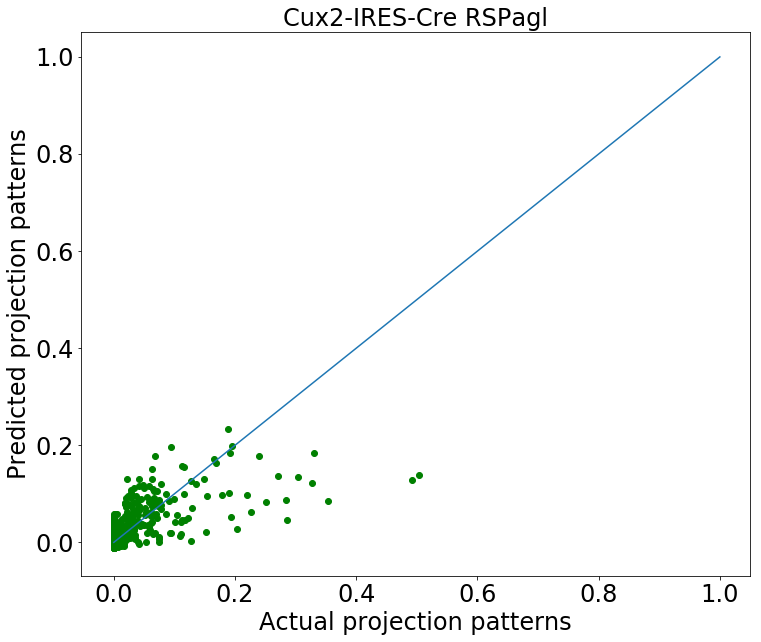

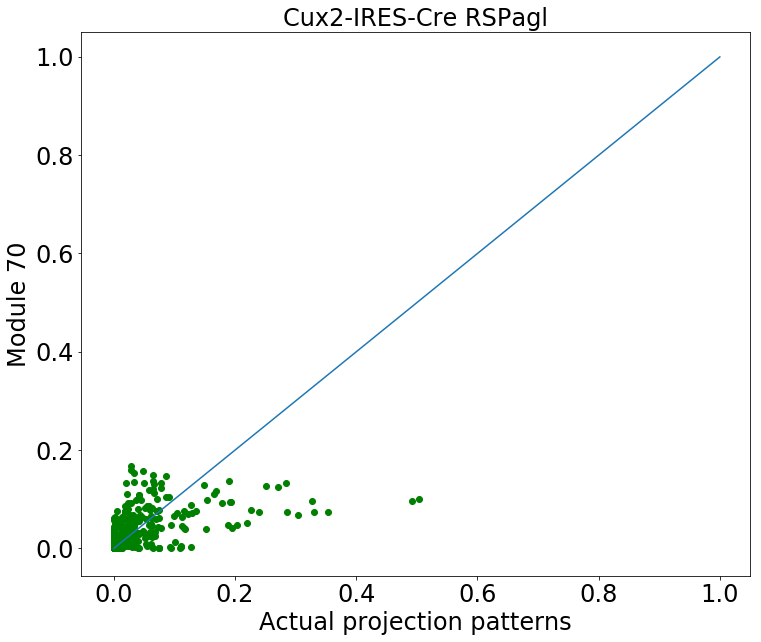

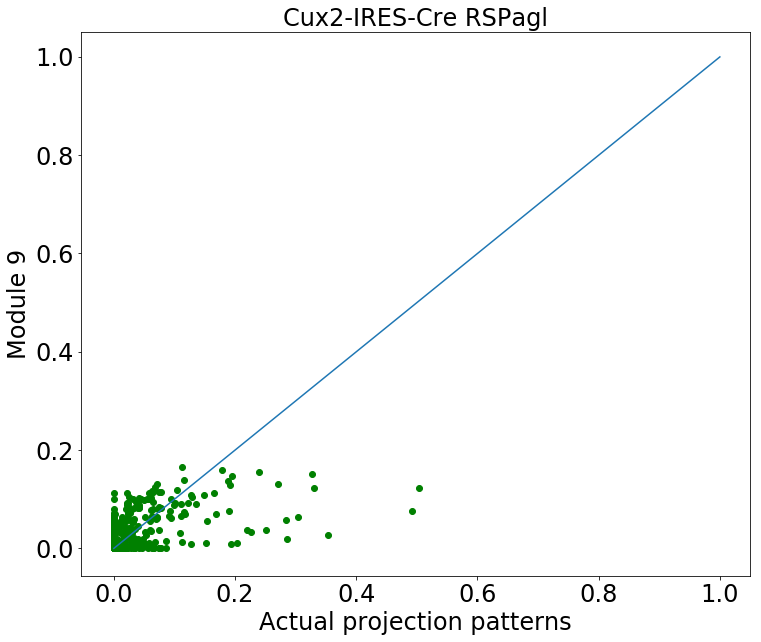

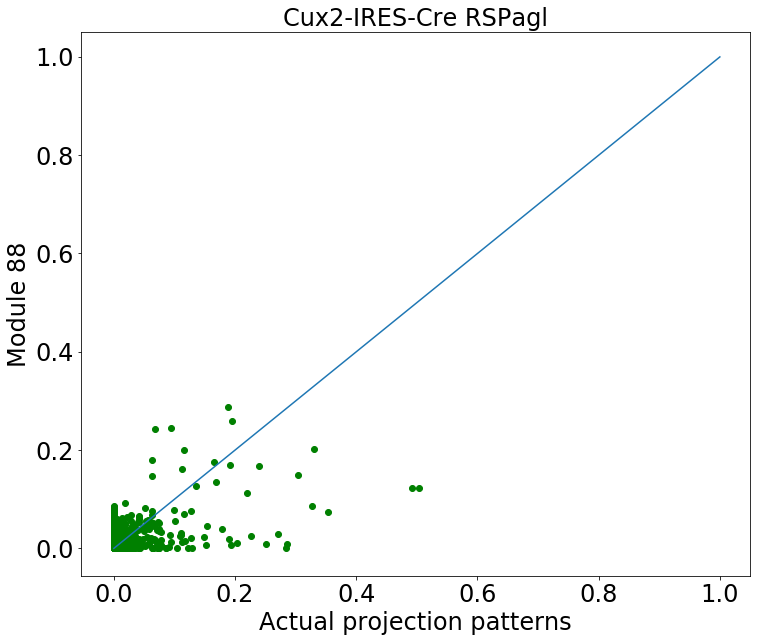

In [71]:
def ScatterIt(A,B,fname,xlabel,ylabel, title):
    # Make a scatter plot for the PAA experiment in order to prove our point that it can be reconstructed from basis vectors
    plt.figure(figsize = (12,10))
    #plt.xticks(np.arange(0,1.05,0.1))
    #plt.yticks(np.arange(0,1.05,0.1))
    plt.scatter(A, B, c = 'g')
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelsize = 24)
    ax.yaxis.set_tick_params(labelsize = 24)
    #plt.axis('scaled')
    plt.xlabel(xlabel, fontsize = 24)
    plt.ylabel(ylabel, fontsize = 24)
    plt.title(title, fontsize = 24)
    plt.plot((0,1),(0,1))
    plt.savefig(fname)
    plt.show()

tracer_name = MesoPred.ConDict['Cux2-IRES-Cre']['structure-abbrev'][57]
sel_mods = exp_to_mod_cor['Cux2-IRES-Cre']['top_mods'][57]
ScatterIt(ClfResults_ridge['Cux2-IRES-Cre']['y_actual'][:,57],exp_to_mod_cor['Cux2-IRES-Cre']['y_pred'][57],
          fname = 'paper1_figures/for_paul_20_6_19/scatter_of_{}_to_mods.jpg'.format(tracer_name),
          xlabel = 'Actual projection patterns', ylabel = 'Predicted projection patterns',
          title = 'Cux2-IRES-Cre {}'.format(tracer_name))
for mod in exp_to_mod_cor['Cux2-IRES-Cre']['top_mods'][57]:
    ScatterIt(ClfResults_ridge['Cux2-IRES-Cre']['y_actual'][:,57], Code[:,mod],
    fname = 'paper1_figures/for_paul_20_6_19/scatter_of_{}_to_mod_{}.jpg'.format(tracer_name,mod),
    xlabel = 'Actual projection patterns', ylabel = 'Module {}'.format(mod),
    title = 'Cux2-IRES-Cre {}'.format(tracer_name))


#### Make a histogram with the pearson correlation between all projection patterns and their reconstruction from top three modules

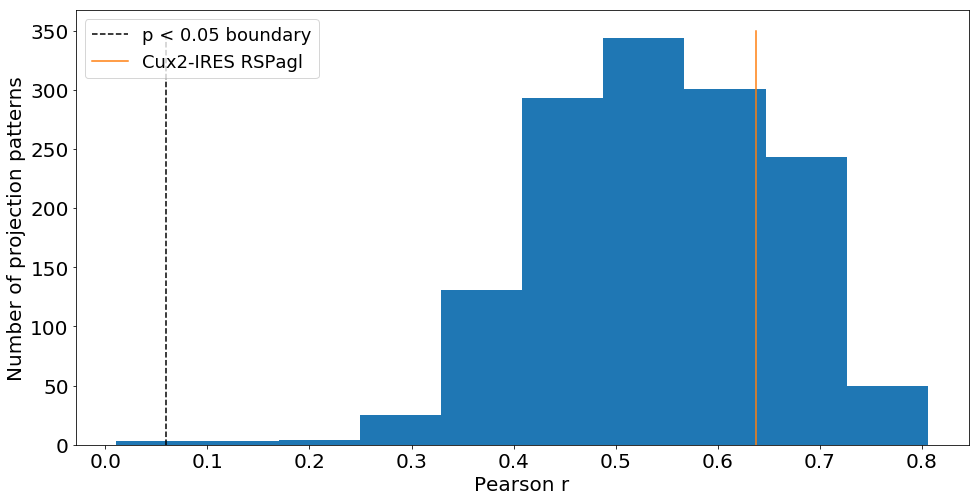

In [17]:
all_mod_to_proj_cor = [corr for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['global correlations']]
all_mod_to_proj_p = [corr for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['pval']]
fig = plt.figure(figsize = (16,8))
plt.hist(all_mod_to_proj_cor)
ax = plt.gca()
threshold = all_mod_to_proj_cor[np.argsort(all_mod_to_proj_p)[::-1][1]]
sel_point = exp_to_mod_cor['Cux2-IRES-Cre']['global correlations'][57]
ax.plot([threshold, threshold], [0, 350], "k--")
ax.plot([sel_point, sel_point], [0, 350])
ax.xaxis.set_tick_params(labelsize = 20)
ax.yaxis.set_tick_params(labelsize = 20)
plt.xlabel('Pearson r',fontsize = 20)
plt.ylabel('Number of projection patterns',fontsize = 20)
plt.legend(['p < 0.05 boundary','Cux2-IRES RSPagl'], fontsize = 18, loc = 'upper left')
plt.savefig('paper1_figures/for_paul_20_6_19/projection_module_pearson_hist.jpg')

#### Make scatter plot associations between projections and modules

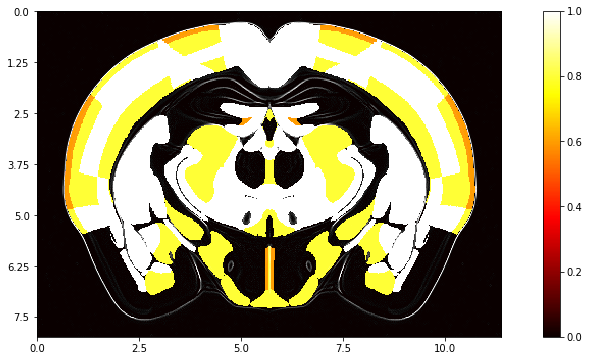

"print 'visualization of RSPagl new code has been completed '\nfor mod in sel_mods:\n    print mod\n    BP_10 = PL.BrainPlotter(resolution = 10)\n    BP_10.fit(projection = Code[:,mod], chosen_indices = MesoPred.params['remaining_indices'])\n    BP_10.plot_flatmap(savefile = 'paper1_figures/for_paul_20_6_19/flatmap_module_{}.jpg'.format(mod))\n    BP_25 = PL.BrainPlotter(resolution = 25)\n    BP_25.fit(projection = Code[:,mod], \n              chosen_indices = MesoPred.params['remaining_indices'])\n    BP_25.plot_slice(savefile = 'paper1_figures/for_paul_20_6_19/brain_slice_module_{}.jpg'.format(mod))\n    print 'visualization of module {} new code has been completed'.format(mod)"

In [12]:
sel_mods = exp_to_mod_cor['Cux2-IRES-Cre']['top_mods'][57]
new_code = Codify_Modules(Code, ClfResults_ridge['wild_type']['y_actual'][:,57], sel_mods)

BP_25 = PL.BrainPlotter(resolution = 25)
BP_10 = PL.BrainPlotter(resolution = 10)
BP_25.fit(projection = ClfResults_ridge['Cux2-IRES-Cre']['y_actual'][:,57], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_10.fit(projection = ClfResults_ridge['Cux2-IRES-Cre']['y_actual'][:,57], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_25.plot_slice(savefile = 'paper1_figures/for_paul_20_6_19/brain_slice_wild_type_{}.jpg'.format(MesoPred.ConDict['Cux2-IRES-Cre']['structure-abbrev'][57]))
BP_10.plot_flatmap(savefile = 'paper1_figures/for_paul_20_6_19/flatmap_wild_type_{}.jpg'.format(MesoPred.ConDict['Cux2-IRES-Cre']['structure-abbrev'][57]))
print 'visualization of {} has been completed'.format(MesoPred.ConDict['Cux2-IRES-Cre']['structure-abbrev'][57])
 
BP_25 = PL.BrainPlotter(resolution = 25)
#BP_10 = PL.BrainPlotter(resolution = 10)
BP_25.fit(projection = new_code, 
          chosen_indices = MesoPred.params['remaining_indices'])
#BP_10.fit(projection = new_code, 
#          chosen_indices = MesoPred.params['remaining_indices'])
BP_25.plot_slice(savefile = 'paper1_figures/for_paul_20_6_19/brain_slice_new_code.jpg')
#BP_10.plot_flatmap(savefile = 'paper1_figures/for_paul_20_6_19/flatmap_new_code.jpg')
print 'visualization of RSPagl new code has been completed '
for mod in sel_mods:
    print mod
    BP_10 = PL.BrainPlotter(resolution = 10)
    BP_10.fit(projection = Code[:,mod], chosen_indices = MesoPred.params['remaining_indices'])
    BP_10.plot_flatmap(savefile = 'paper1_figures/for_paul_20_6_19/flatmap_module_{}.jpg'.format(mod))
    BP_25 = PL.BrainPlotter(resolution = 25)
    BP_25.fit(projection = Code[:,mod], 
              chosen_indices = MesoPred.params['remaining_indices'])
    BP_25.plot_slice(savefile = 'paper1_figures/for_paul_20_6_19/brain_slice_module_{}.jpg'.format(mod))
    print 'visualization of module {} new code has been completed'.format(mod)

### Note down: Cux2-IRES-Cre scored the highest predictive module based model at 57th injection with 0.79 r2 -> gene penalized model

In [91]:
sel_tracers = [(key, np.argmax(module_based_pred[key]['r2']), np.max(module_based_pred[key]['r2'])) for key in module_based_pred.keys()]
print sel_tracers

[('Nr5a1-Cre', 10, 0.68589813153892842), ('Scnn1a-Tg3-Cre', 12, 0.71658998022354115), ('Ntsr1-Cre_GN220', 3, 0.66083538177089807), ('Tlx3-Cre_PL56', 60, 0.73705245159545063), ('Sim1-Cre_KJ18', 15, 0.70751947788424485), ('Rbp4-Cre_KL100', 45, 0.78897961164682717), ('Efr3a-Cre_NO108', 6, 0.65984287028100175), ('Sepw1-Cre_NP39', 8, 0.70790049157394774), ('Emx1-IRES-Cre', 33, 0.71113548287893213), ('Cux2-IRES-Cre', 57, 0.79019904348858894), ('Chrna2-Cre_OE25', 34, 0.74905226665938585), ('A93-Tg1-Cre', 3, 0.68845734927533386), ('Rorb-IRES2-Cre', 21, 0.74470569087272942), ('wild_type', 260, 0.79997957749358073), ('Syt6-Cre_KI148', 17, 0.67796298691234191)]


In [93]:
sel_tracer = np.argmax(module_based_pred)
scaler              = StandardScaler()
pipeline            = Pipeline([('scaler', scaler), ('stability_selection', stability_selection)])
pipeline.fit(Code, ClfResults_ridge['Cux2-IRES-Cre']['y_actual'][:,57])
tmp = pipeline.get_params()['stability_selection'].get_support()
mods_again = [i for i, x in enumerate(tmp) if x]
stability_scores = pipeline.get_params()['stability_selection'].scores_
module_blacklist = np.argsort(stability_scores)[::-1][0:19]
#pk.dump(module_blacklist, open('paper1_figures/module_blacklist.pkl','wb'))
clear_output()
print module_blacklist

[ 88   9  70  21  16  64   1  92 124 162 192 130 170  62  18  98  53 109
  15]


# Grange Method Revisited Part !!!

### Cell-type rna data were taken from Neuroexpresso github page:
https://github.com/PavlidisLab/neuroExpressoAnalysis

In [14]:
infile = 'n_expressoExprWithRNAseq.csv'
CelltypeMat, gene_annot,cell_annot = PL.CellTypeParser(infile)

In [26]:
sg_cell_annot, sg_cell_id = np.unique(gene_annot, return_index = True)
ish_annot, ish_id         = np.unique(MesoPred.params['Gene Acronyms'], return_index = True)
tmp                       = set.intersection(set(ish_annot),set(sg_cell_annot))
ish_id2      = [ish_id[idx] for idx,val in enumerate(ish_annot) if val in tmp]
sg_cell_id2  = [sg_cell_id[idx] for idx,val in enumerate(sg_cell_annot) if val in tmp]

In [27]:
ish_data     = ClfResults_ridge['wild_type']['Gene Expression'][:,ish_id2]
sg_cell_data = np.transpose(CelltypeMat[sg_cell_id2,:])
sg_cell_data = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0, verbose=0, copy=True).fit_transform(sg_cell_data)

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [82]:
#G_Code, G_Atoms, G_dlsc = MesoPred.DictionaryDecomposition(np.transpose(ish_data), 
#                                                           x = np.transpose(sg_cell_data[potential_ct,:]), 
#                                                           n_comp = np.shape(sg_cell_data[potential_ct,:])[0],
#                                                           alpha = 0.1, state = 0)
#G_Atoms = np.transpose(G_Atoms); G_Code = np.transpose(G_Code) 
#pk.dump(G_Atoms,open('paper1_figures/for_paul_20_6_19/Grange_Atoms.pkl', 'wb'))
#pk.dump(G_Code,open('paper1_figures/for_paul_20_6_19/Grange_Code.pkl', 'wb'))
#pk.dump(G_dlsc,open('paper1_figures/for_paul_20_6_19/Grange_mdl.pkl', 'wb'))
G_Atoms = pk.load(open('paper1_figures/for_paul_20_6_19/Grange_Atoms.pkl', 'rb'))
G_Code  = pk.load(open('paper1_figures/for_paul_20_6_19/Grange_Code.pkl', 'rb'))
G_dlsc  = pk.load(open('paper1_figures/for_paul_20_6_19/Grange_mdl.pkl', 'rb'))
g_module_based_pred, g_all_scores = Predictive_Shortcut(ClfResults_ridge, G_Code) 
clear_output()
print np.max(g_all_scores)

0.709219395923


### Crucial step: compare with unconstrained and bicluster the data

In [31]:
SimMat_dist = np.zeros((len(Code[0]), len(G_Code[0])))
SimMat_cor = np.zeros((len(Code[0]), len(G_Code[0])))
G_Code_sc = StandardScaler().fit_transform(G_Code)
Code_sc = StandardScaler().fit_transform(Code)
for ctype in range(len(G_Code[0])):
    for module in range(len(Code[0])):
        #SimMat_dist[module,ctype] = sci.spatial.distance.euclidean(G_Code[:,ctype]/(1.0*np.linalg.norm(G_Code[:,ctype])),
        #                                                      Code[:,module]/(1.0*np.linalg.norm(Code[:,module])))
        SimMat_dist[module,ctype] = sci.spatial.distance.euclidean(G_Code_sc[:,ctype],
                                                              Code_sc[:,module])
        #SimMat_cor[module,ctype] = sci.stats.spearmanr(G_Code_sc[:,ctype],
        #                                           Code_sc[:,module])[0]
        SimMat_cor[module,ctype] = sci.stats.spearmanr(G_Code[:,ctype],
                                                   Code[:,module])[0]
        clear_output()  

#### Finding associations between the two decompositions:

#### Take note: the constrained and unconstrained module arrays are full rank

In [108]:
epsi = np.finfo(np.float64).eps

2.22044604925e-16


In [119]:
from numpy.linalg import matrix_rank
u,s,vh = np.linalg.svd(Code)
epsi = np.finfo(np.float64).eps
thr =  s.max() * max(Code.shape) * epsi * 10e9
print 'our threshold is {} and the actual one is {}'.format(thr, s.max() * max(Code.shape) * epsi)

rank1 = matrix_rank(Code, tol = thr)
rank2 = matrix_rank(G_Code)
rank3 = matrix_rank(ClfResults_ridge['wild_type']['Gene Expression'])
print rank1,rank2,rank3

our threshold is 0.00966881924424 and the actual one is 9.66881924424e-13
199 33 427


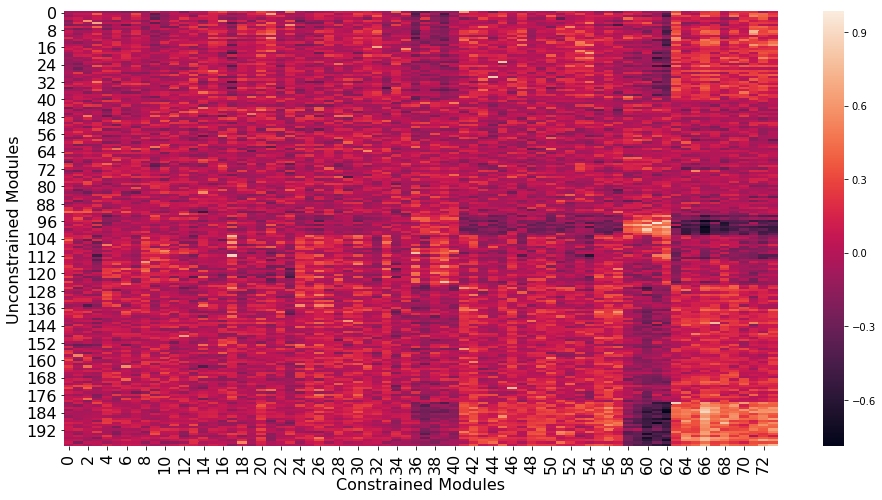

In [82]:
from sklearn.cluster import bicluster
module_biclsusters = bicluster.SpectralBiclustering(n_clusters = 6, random_state = 0)
module_biclsusters.fit(SimMat_cor)
row_labels = module_biclsusters.row_labels_
column_labels = module_biclsusters.column_labels_

sorted_SimMat = np.zeros(np.shape(SimMat_cor))
row_reorder = []; column_reorder = []
for row in np.unique(row_labels):
    row_reorder.extend([idx for idx,val in enumerate(row_labels) if val == row])
for column in np.unique(column_labels):
    column_reorder.extend([idx for idx,val in enumerate(column_labels) if val == column])
    
sorted_SimMat = SimMat_cor[row_reorder,:]
sorted_SimMat = sorted_SimMat[:,column_reorder]
fig = plt.figure(figsize = (16,8))
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
sns.heatmap(sorted_SimMat)
plt.ylabel('Unconstrained Modules', fontsize = 16)
plt.xlabel('Constrained Modules', fontsize = 16)
plt.savefig('paper1_figures/for_paul_20_6_19/module_heatmap.jpg')

In [41]:
np.min(g_all_scores), np.median(g_all_scores), np.max(g_all_scores), sci.stats.iqr(g_all_scores)

(0.060051138340797339,
 0.45578207760763645,
 0.75599189604367667,
 0.18950412776424597)

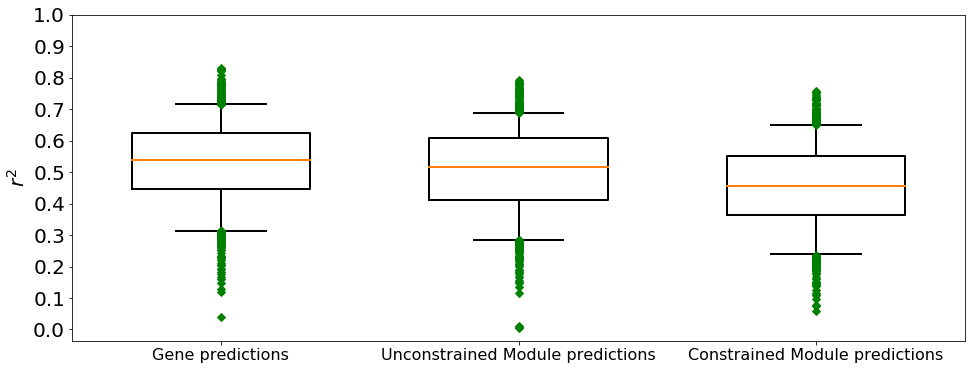

In [39]:
fig = plt.figure(figsize = (16,6))
ax = plt.gca()
#plt.tight_layout()
#plt.rcParams['figure.figsize']
plt.rcParams['axes.facecolor'] = 'white'
box = plt.boxplot([gene_scores, all_scores, g_all_scores], 0, 'gD', widths = 0.6, whis = [5,95])
for key in box.keys():
        for bp in box[key]:
            bp.set(linewidth = 2)
plt.yticks(np.arange(0.0,1.1,0.1))
ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 20)
plt.xticks([1,2,3],['Gene predictions', 'Unconstrained Module predictions', 'Constrained Module predictions'])
plt.ylabel(r'$r^2$', fontsize = 20)
plt.savefig('paper1_figures/for_paul_20_6_19/module_to_gene_pred.jpg')
plt.savefig('paper1_figures/module_to_gene_pred.eps')
plt.show()

### Last step: Hamming distance between modules and predictions

In [19]:
Ontology_per_projection = pk.load(open('paper1_figures/Ontology_per_projection.pkl','rb')) 
Ontology_per_module = pk.load(open('paper1_figures/Ontology_per_module.pkl','rb')) 

In [10]:
top_num = 50
Ontology_per_module = {}
for module in range(len(Code[0])):
    mod_gene_ids = np.argsort(np.nonzero(Atoms[module,:]))[::-1][0] 
    gene_list  = [MesoPred.params['Gene Ids'][val] for val in mod_gene_ids if MesoPred.params['Gene Ids'][val] is not None]
    Ontology_per_module[module] = MesoPred.GOenrichment(gene_list)
    
pk.dump(Ontology_per_module, open('paper1_figures/Ontology_per_module.pkl','wb'))            

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Bioconductor version 3.8 (BiocInstaller 1.32.1), ?biocLite for help

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: AnnotationDbi

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__in

In [20]:
def jaccard_similarity(list1, group):
    return [len(set(list1).intersection(set(list2)))/(1.0*len(set(list1).union(set(list2)))) if len(set(list1)) > 0 and len(set(list2)) > 0  else 0
            for mod,list2 in group.items()]

Ontology_Dict = {}
for key in ClfResults_ridge.keys():
    print key
    Ontology_Dict[key] = Parallel(n_jobs = -1)(delayed(jaccard_similarity)(Ontology_per_projection[key][proj], Ontology_per_module) for proj in Ontology_per_projection[key].keys())

Nr5a1-Cre
Scnn1a-Tg3-Cre
Ntsr1-Cre_GN220
Emx1-IRES-Cre
Efr3a-Cre_NO108
Rbp4-Cre_KL100
Sim1-Cre_KJ18
Chrna2-Cre_OE25
Sepw1-Cre_NP39
Tlx3-Cre_PL56
Cux2-IRES-Cre
A93-Tg1-Cre
Rorb-IRES2-Cre
wild_type
Syt6-Cre_KI148


In [86]:
#pk.dump(Ontology_Dict, open('paper1_figures/Ontology_Dict.pkl','wb'))   
Ontology_Dict = pk.load(open('paper1_figures/Ontology_Dict.pkl','rb'))   

In [75]:
def PostSyn(lista):
    return len([val for val in lista if 'postsyn' in val])

In [78]:
print len([val for val in Ontology_per_module.values() if PostSyn(val) > 0])/200.0
print len([val2 for val in Ontology_per_projection.values() for val2 in val.values() if PostSyn(val2) > 0]) 
print np.median([len(val) for val in Ontology_per_module.values() if len(val) > 0])
print np.median([len(val2) for val in Ontology_per_projection.values() for val2 in val.values()])

1.0
977
39.0
12.0


0.358490566038 0.380952380952 0.347826086957


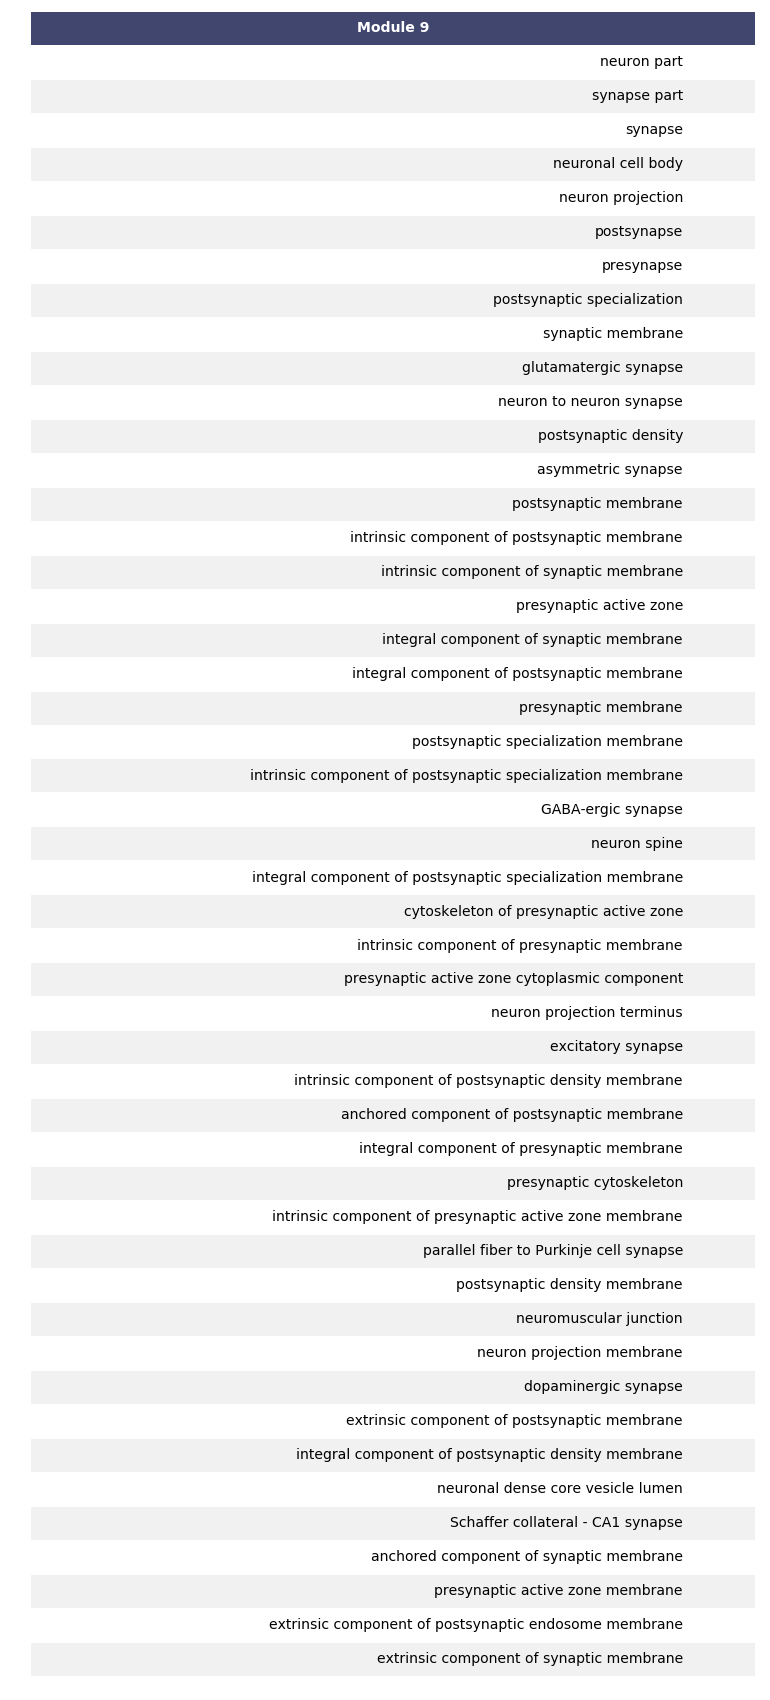

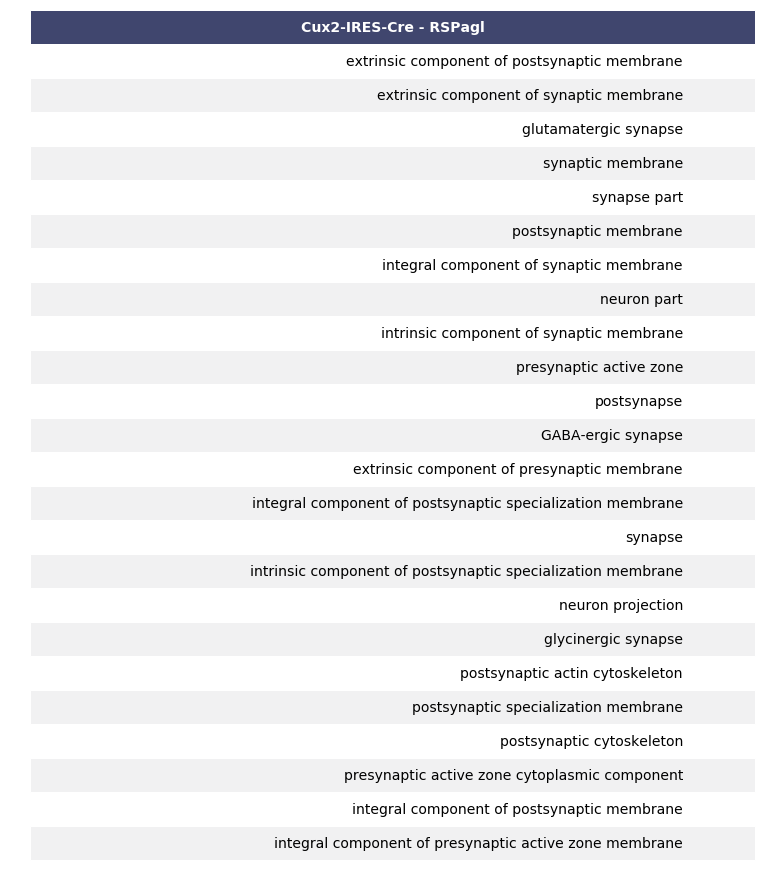

In [68]:
GODict = {'Cux2-IRES-Cre - {}'.format(MesoPred.ConDict['Cux2-IRES-Cre']['structure-abbrev'][57]): Ontology_per_projection['Cux2-IRES-Cre'][57]}
GODict2 = {'Module 9': Ontology_per_module[9]}
GO_DF = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in GODict.items() ])) 
GO_DF2 = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in GODict2.items() ])) 
PL.render_mpl_table(GO_DF2)
plt.savefig('paper1_figures/for_paul_20_6_19/module_9_ontology.jpg')
PL.render_mpl_table(GO_DF)
plt.savefig('paper1_figures/for_paul_20_6_19/Cux2_RSPagl_ontology.jpg')
print Ontology_Dict['Cux2-IRES-Cre'][57][9], Ontology_Dict['Cux2-IRES-Cre'][57][70], Ontology_Dict['Cux2-IRES-Cre'][57][88]

## Moral of the day (4-7-2019):   
#### No significant correlation is found between projection-module correlations and projection-module ontology similarities

In [55]:
listA = []; listB = []; cnt = 0
for key in exp_to_mod_cor.keys():
    for tracer in range(len(exp_to_mod_cor[key]['local correlations'])):
        A = exp_to_mod_cor[key]['local correlations'][tracer]
        top_mods = exp_to_mod_cor[key]['top_mods'][tracer]
        B = [Ontology_Dict[key][tracer][val] for val in top_mods]
        if len(np.unique(B)) > 1: rho = sci.stats.spearmanr(A,B)[0]; listA.append(rho); listB.append(all_scores[cnt]) 
        cnt +=1
        
print sci.stats.pearsonr(listA,listB)        
'''all_mod_to_proj_cor = [corr2 for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['local correlations'] for corr2 in corr]
all_mod_to_proj_jac = [Ontology_Dict[key][idx][val] for key in Ontology_Dict.keys() for idx,jac in enumerate(Ontology_Dict[key]) for val in exp_to_mod_cor[key]['top_mods'][idx]]
print np.shape(all_mod_to_proj_cor),np.shape(all_mod_to_proj_jac)
plt.scatter(all_mod_to_proj_cor,all_mod_to_proj_jac)
sci.stats.spearmanr(all_mod_to_proj_cor,all_mod_to_proj_jac)'''

(0.17836150959330679, 7.9448879997595277e-11)


"all_mod_to_proj_cor = [corr2 for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['local correlations'] for corr2 in corr]\nall_mod_to_proj_jac = [Ontology_Dict[key][idx][val] for key in Ontology_Dict.keys() for idx,jac in enumerate(Ontology_Dict[key]) for val in exp_to_mod_cor[key]['top_mods'][idx]]\nprint np.shape(all_mod_to_proj_cor),np.shape(all_mod_to_proj_jac)\nplt.scatter(all_mod_to_proj_cor,all_mod_to_proj_jac)\nsci.stats.spearmanr(all_mod_to_proj_cor,all_mod_to_proj_jac)"